In [1]:
import numpy as np
import io
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# 데이터 준비

In [2]:
import pathlib

data_dir = "E:\\flower_photos"
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

WindowsPath('E:/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [5]:
batch_size = 32
img_height = 250
img_width = 250

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [8]:
for f in list_ds.take(5):
    print(f.numpy())

b'E:\\flower_photos\\sunflowers\\14144522269_bc20029375_m.jpg'
b'E:\\flower_photos\\roses\\14408977935_a397e796b8_m.jpg'
b'E:\\flower_photos\\roses\\15032112248_30c5284e54_n.jpg'
b'E:\\flower_photos\\daisy\\5434742166_35773eba57_m.jpg'
b'E:\\flower_photos\\dandelion\\13881700933_69a750d418_n.jpg'


In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [10]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [11]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


#### 파일 경로를 (img, label) 쌍으로 변환하는 간단한 함수 작성

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [35]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


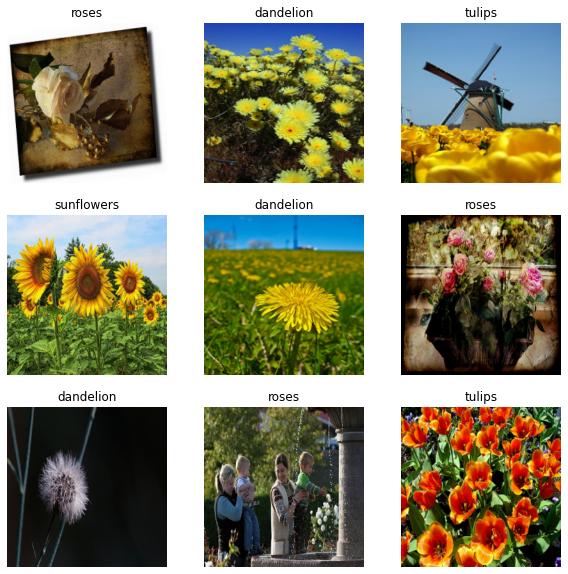

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 모델 빌드하기

In [19]:
"""
from tensorflow.keras.applications import ResNet50
from keras.models import Model

input = tf.keras.layers.Input(shape=(img_height, img_width, 3))
model = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')

x = model.output
x = tf.keras.layers.Dense(256, activation=None)(x) # No activation on final dense layer
x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x) # L2 normalize embeddings
model = Model(model.input, x)
"""

"\nfrom tensorflow.keras.applications import ResNet50\nfrom keras.models import Model\n\ninput = tf.keras.layers.Input(shape=(img_height, img_width, 3))\nmodel = ResNet50(input_tensor=input, include_top=False, weights=None, pooling='max')\n\nx = model.output\nx = tf.keras.layers.Dense(256, activation=None)(x) # No activation on final dense layer\nx = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x) # L2 normalize embeddings\nmodel = Model(model.input, x)\n"

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(img_height,img_width,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# 훈련 및 평가하기

In [38]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [39]:
history = model.fit(
    train_ds,
    epochs=5)

Epoch 1/5
92/92 [==============================] - 10s 103ms/step - loss: 0.9474
Epoch 2/5
92/92 [==============================] - 10s 103ms/step - loss: 0.9012
Epoch 3/5
92/92 [==============================] - 10s 108ms/step - loss: 0.8904
Epoch 4/5
92/92 [==============================] - 10s 104ms/step - loss: 0.8796
Epoch 5/5
92/92 [==============================] - 10s 106ms/step - loss: 0.8675


In [23]:
# Evaluate the network
results = model.predict(val_ds)

In [24]:
results

array([[-0.09546452, -0.0467106 , -0.07636089, ..., -0.04073996,
         0.00871283, -0.0934184 ],
       [ 0.05878888,  0.10074914, -0.04164003, ..., -0.04741054,
         0.06642885,  0.02267223],
       [ 0.02344858, -0.05584429,  0.09794468, ...,  0.04920054,
        -0.09075593,  0.06861842],
       ...,
       [ 0.0424209 ,  0.04885256,  0.0547129 , ...,  0.04938229,
        -0.0042042 ,  0.10365701],
       [ 0.08463243,  0.09797553,  0.00164075, ..., -0.01385704,
         0.04897236,  0.06826542],
       [ 0.01907041,  0.05496006, -0.0949671 , ..., -0.09543913,
         0.07194854, -0.09811809]], dtype=float32)

In [25]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(val_ds):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


In [26]:
history.history

{'loss': [0.9311988353729248,
  0.8962042927742004,
  0.8859066367149353,
  0.8766463398933411,
  0.8790156245231628]}

In [27]:
model.evaluate(val_ds, batch_size=32)

23/23 [==============================] - 1s 40ms/step - loss: 0.8894


0.8893566727638245

In [28]:
# Embedding Projecto
# https://projector.tensorflow.org/

In [41]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

In [43]:
len(train_dataset)

1875

In [44]:
len(test_dataset)

313